In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import json

from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
nuggets = [team for team in nba_teams if team['abbreviation'] == 'DEN'][0]
nuggets_id = nuggets['id']

In [3]:
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=nuggets_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42018,1610612743,DEN,Denver Nuggets,0041800151,2019-04-13,DEN vs. SAS,L,239,96,...,0.667,13,33,46,25,8,3,10,18,-5.0
1,22018,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,241,99,...,0.647,12,41,53,23,6,4,12,12,4.0
2,22018,1610612743,DEN,Denver Nuggets,0021801217,2019-04-09,DEN @ UTA,L,241,108,...,0.636,3,28,31,24,9,3,7,28,-10.0
3,22018,1610612743,DEN,Denver Nuggets,0021801206,2019-04-07,DEN @ POR,L,241,108,...,0.550,12,30,42,24,9,4,10,26,-7.0
4,22018,1610612743,DEN,Denver Nuggets,0021801190,2019-04-05,DEN vs. POR,W,240,119,...,0.897,12,27,39,27,10,4,9,19,9.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24844e80>]],
      dtype=object)

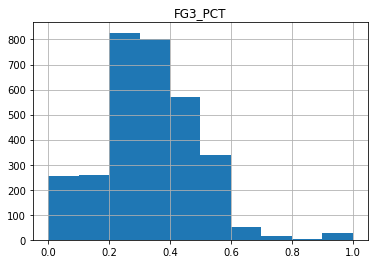

In [4]:
games.hist('FG3_PCT')

# What factors lead to the 2018-19 Nuggets scoring more points?

In [5]:
this_season = games[games['SEASON_ID'] == '22018']
this_season.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
1,22018,1610612743,DEN,Denver Nuggets,0021801228,2019-04-10,DEN vs. MIN,W,241,99,...,0.647,12,41,53,23,6,4,12,12,4.0
2,22018,1610612743,DEN,Denver Nuggets,0021801217,2019-04-09,DEN @ UTA,L,241,108,...,0.636,3,28,31,24,9,3,7,28,-10.0
3,22018,1610612743,DEN,Denver Nuggets,0021801206,2019-04-07,DEN @ POR,L,241,108,...,0.550,12,30,42,24,9,4,10,26,-7.0
4,22018,1610612743,DEN,Denver Nuggets,0021801190,2019-04-05,DEN vs. POR,W,240,119,...,0.897,12,27,39,27,10,4,9,19,9.0
5,22018,1610612743,DEN,Denver Nuggets,0021801173,2019-04-03,DEN vs. SAS,W,242,113,...,0.583,8,39,47,41,6,3,14,20,28.0


In [6]:
list(this_season)

['SEASON_ID',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PLUS_MINUS']

In [25]:
corr_matrix = this_season.corr()
corr_matrix.head()

,TEAM_ID,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
TEAM_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIN,NaN,1.000000,0.543068,0.458194,0.489913,0.213336,0.247059,0.278996,0.184817,0.265677,...,0.060600,0.094485,0.260322,0.243054,0.387327,-0.114763,0.230160,-0.044623,-0.076709,0.027689
PTS,NaN,0.543068,1.000000,0.895484,0.434675,0.713236,0.553524,0.266696,0.556004,0.329466,...,0.167746,0.092514,0.200403,0.196572,0.656615,-0.012829,0.070810,-0.172457,0.149118,0.493096
FGM,NaN,0.458194,0.895484,1.000000,0.446891,0.810073,0.456186,0.208323,0.463300,-0.057315,...,0.134083,0.018986,0.178284,0.144580,0.720053,-0.112341,0.030974,-0.183924,0.120266,0.501265
FGA,NaN,0.489913,0.434675,0.446891,1.000000,-0.158128,0.191971,0.447133,-0.073478,0.063763,...,0.055511,0.537310,0.312776,0.494799,0.279583,-0.039502,0.300272,-0.242902,-0.034584,-0.013437


In [26]:
corr_matrix['PTS'].sort_values(ascending = False).head()

PTS        1.000000
FGM        0.895484
FG_PCT     0.713236
AST        0.656615
FG3_PCT    0.556004
Name: PTS, dtype: float64

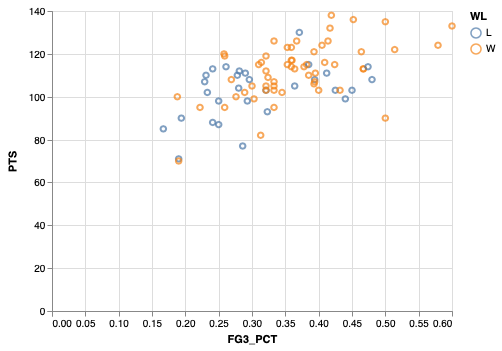

In [9]:
alt.Chart(this_season).mark_point().encode(
    x='FG3_PCT',
    y='PTS',
    color='WL'
)

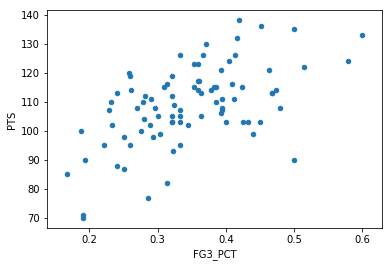

In [10]:
this_season.plot.scatter('FG3_PCT','PTS')

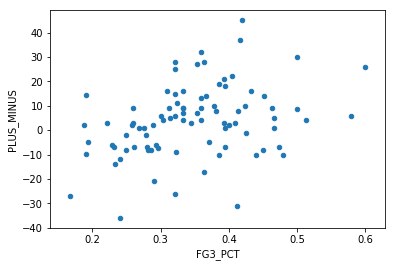

In [11]:
this_season.plot.scatter('FG3_PCT','PLUS_MINUS')

In [28]:
m0 = smf.ols(formula = 'PTS ~ FG3_PCT + FG_PCT + FT_PCT + FTA + REB',data=this_season).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     55.98
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           7.35e-25
Time:                        16:27:27   Log-Likelihood:                -284.68
No. Observations:                  87   AIC:                             581.4
Df Residuals:                      81   BIC:                             596.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -31.1566      9.742     -3.198      0.002     -50.541     -11.772
FG3_PCT       42.2066     10.023      4.211      0.000      22.264      62.149
FG_PCT       150.8757     15.899      9.490      0.000     119.241     182.510
FT_PCT        24.4088      6.853      3.562      0.001      10.774      38.044
FTA            0.5688      0.099      5.724      0.000       0.371       0.767
REB            0.5456      0.103      5.296      0.000       0.341       0.751
==============================================================================
Omnibus:                        0.637   Durbin-Watson:                   1.200
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.536
Skew:                          -0.190   Prob(JB):                        0.765
Kurtosis:                       2.939   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Effect of 3 Point Shooting?

In [84]:
good_3_pt = this_season[this_season['FG3_PCT'] >= 0.35]
good_3_pt.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
1,22018,1610612743,DEN,Denver Nuggets,0021801217,2019-04-09,DEN @ UTA,L,241,108,...,0.636,3,28,31,24,9,3,7,28,-10.0
2,22018,1610612743,DEN,Denver Nuggets,0021801206,2019-04-07,DEN @ POR,L,241,108,...,0.550,12,30,42,24,9,4,10,26,-7.0
4,22018,1610612743,DEN,Denver Nuggets,0021801173,2019-04-03,DEN vs. SAS,W,242,113,...,0.583,8,39,47,41,6,3,14,20,28.0
7,22018,1610612743,DEN,Denver Nuggets,0021801133,2019-03-29,DEN @ OKC,W,240,115,...,0.833,7,32,39,30,6,1,12,21,10.0
11,22018,1610612743,DEN,Denver Nuggets,0021801082,2019-03-22,DEN @ NYK,W,241,111,...,0.842,17,45,62,24,5,5,8,15,18.0


In [85]:
good_3_pt['WL'].value_counts()

W    32
L    10
Name: WL, dtype: int64

In [86]:
this_season['WL'].value_counts()

W    57
L    30
Name: WL, dtype: int64

In [87]:
print(good_3_pt['PLUS_MINUS'].mean())
print(this_season['PLUS_MINUS'].mean())

8.447619047619048
3.8781609195402296


# Spurs Games

In [16]:
spurs_games_df = this_season[this_season['MATCHUP'].str.contains('SAS')]

In [18]:
spurs_games_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
5,22018,1610612743,DEN,Denver Nuggets,0021801173,2019-04-03,DEN vs. SAS,W,242,113,...,0.583,8,39,47,41,6,3,14,20,28.0
20,22018,1610612743,DEN,Denver Nuggets,0021800954,2019-03-04,DEN @ SAS,L,239,103,...,1.000,8,35,43,27,5,3,12,17,-1.0
50,22018,1610612743,DEN,Denver Nuggets,0021800524,2018-12-28,DEN vs. SAS,W,240,102,...,0.824,16,36,52,29,5,4,20,20,3.0
51,22018,1610612743,DEN,Denver Nuggets,0021800510,2018-12-26,DEN @ SAS,L,239,103,...,0.652,11,36,47,29,10,3,12,17,-8.0


In [22]:
spurs_corr = spurs_games_df.corr()
spurs_corr.head()

,TEAM_ID,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
TEAM_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIN,NaN,1.000000,0.908622,0.848528,-0.596121,0.960208,-0.671306,-0.605839,-0.698481,-0.220113,...,-0.613476,-0.187317,0.952579,0.255812,0.957073,-0.297044,0.000000,0.249029,0.816497,0.977471
PTS,NaN,0.908622,1.000000,0.854515,-0.269593,0.854949,-0.303595,-0.218225,-0.348413,-0.407998,...,-0.645761,-0.557406,0.945905,-0.126387,0.978320,-0.094465,-0.417620,-0.178190,0.500773,0.932559
FGM,NaN,0.848528,0.854515,1.000000,-0.145616,0.941644,-0.474685,-0.354954,-0.556394,-0.697282,...,-0.190119,-0.503322,0.731310,-0.171842,0.801692,-0.588118,-0.200000,0.017609,0.577350,0.940000
FGA,NaN,-0.596121,-0.269593,-0.145616,1.000000,-0.470135,0.828470,0.879432,0.766323,-0.586883,...,0.584985,-0.644604,-0.553103,-0.920167,-0.460814,0.048293,-0.651441,-0.779370,-0.862840,-0.427850


In [29]:
spurs_corr['PLUS_MINUS'].sort_values(ascending=False).head()

PLUS_MINUS    1.000000
FG_PCT        0.984459
MIN           0.977471
FGM           0.940000
AST           0.939940
Name: PLUS_MINUS, dtype: float64

In [30]:
spurs_corr['PTS'].sort_values(ascending=False).head()

PTS           1.000000
AST           0.978320
DREB          0.945905
PLUS_MINUS    0.932559
MIN           0.908622
Name: PTS, dtype: float64